In [53]:
!pip install tensorflow

  Using cached tensorflow-2.7.0-cp38-cp38-win_amd64.whl (430.8 MB)
  Using cached tensorboard-2.7.0-py3-none-any.whl (5.8 MB)
  Using cached tensorflow_estimator-2.7.0-py2.py3-none-any.whl (463 kB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached libclang-12.0.0-py2.py3-none-win_amd64.whl (13.1 MB)
  Using cached h5py-3.6.0-cp38-cp38-win_amd64.whl (2.8 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import re
import shutil
from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle
from pytorch_transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from torch.optim import Adam
import torch.nn.functional as F
import textwrap
import keras

In [73]:
data = pd.read_excel('../data/TypeStress.xlsx', sheet_name = '1316')
data = data[['Municode', 'year', 'Name', 'County', 'TypeofStress']]
data_2 = pd.read_excel('../data/TypeStress.xlsx', sheet_name = '1719')
data_2 = data_2[['Entity Name', 'County', 'year', 'Municode', 'Type of Stress']]
data_2.rename(columns = {'Entity Name': 'County', 'Type of Stress': 'TypeofStress', 'County': 'Name'}, inplace=True)
city_types = pd.concat([data, data_2], axis = 0)

In [75]:
city_types

,Municode,year,Name,County,TypeofStress
0,50203000000,2013,Auburn,Cayuga,Inconclusive
1,550262000000,2013,Yonkers,Westchester,Inconclusive
2,330245000000,2014,Port Jervis,Orange,Inconclusive
3,380247000000,2014,Rensselaer,Rensselaer,Inconclusive
4,330245000000,2015,Port Jervis,Orange,Inconclusive
...,...,...,...,...,...
118,550261000000,2018,Westchester,City of White Plains,No Designation
119,550261000000,2019,Westchester,City of White Plains,No Designation
120,550262000000,2017,Westchester,City of Yonkers,Susceptible Fiscal Stress
121,550262000000,2018,Westchester,City of Yonkers,Moderate Fiscal Stress


In [76]:
# target 종류 numeric label 부여하기
target = []
for idx, city in city_types.iterrows():
    if city['TypeofStress'] == 'No Designation':
        target.append(0)
    elif city['TypeofStress'] == 'Susceptible Fiscal Stress':
        target.append(1)
    elif city['TypeofStress'] == 'Moderate Fiscal Stress':
        target.append(2)
    elif city['TypeofStress'] == 'Significant Fiscal Stress':
        target.append(3)
    else:
        target.append('nan')    

In [77]:
city_types['target'] = target

In [79]:
# Target 데이터가 nan가 아닌 데이터 갯수
print(len(city_types[city_types['target']!='nan']))
new_city_types = city_types[city_types['target']!='nan']

338


In [100]:
new_city_types.sort_values(by ='Name')[:15]

,Municode,year,Name,County,TypeofStress,target
222,10201000000,2016,Albany,Albany,Significant Fiscal Stress,3
220,10201000000,2015,Albany,Albany,Significant Fiscal Stress,3
24,10201000000,2013,Albany,Albany,No Designation,0
20,10209000000,2018,Albany,City of Cohoes,No Designation,0
0,10201000000,2017,Albany,City of Albany,Moderate Fiscal Stress,2
1,10201000000,2018,Albany,City of Albany,Susceptible Fiscal Stress,1
19,10209000000,2017,Albany,City of Cohoes,No Designation,0
218,10201000000,2014,Albany,Albany,Significant Fiscal Stress,3
115,10260000000,2017,Albany,City of Watervliet,Significant Fiscal Stress,3
116,10260000000,2018,Albany,City of Watervliet,Susceptible Fiscal Stress,1


In [152]:
path = '../data/MDNA_txt/'
temp = []
file_list = os.listdir(path)
for file in file_list:
    city = re.sub('[^a-z|A-Z]|txt', '', file)
#     print(city)
    year = int(re.findall('\d+',file)[0])
#     print(year)
    municode = str(int(re.findall('\d+', file)[1]))
#     print(municode)
    city_lookup = new_city_types[new_city_types['Name'] == city]
    subset = city_lookup[city_lookup['year'] == year]
    subset = subset[subset['Municode'].apply(lambda x: str(x)[:len(municode)]) == municode]
#     print(subset)
    if subset.empty == False:
        label = int(subset['target'])
        temp.append([file, label])
#         shutil.move(path+file, destination+f"{label}/")
df = pd.DataFrame(temp)

In [162]:
# 데이터에 사용되는 파일들의 dataframe
df[1].value_counts()

0    71
1     8
2     5
3     4
Name: 1, dtype: int64

In [154]:
# raw data인 text 데이터를 불러온 dataframe
temp = []
for idex, data in df.iterrows():
    with open(f'../data/MDNA_txt/{str(data[0])}', 'rt',encoding = 'unicode_escape') as f:
        a = f.read()
        a = re.sub(r'&amp;', '&',a)
        a = re.sub(r'(@.*?)[\s]', ' ', a)
        a = re.sub(r'\n', '', a)
        a = re.sub(r'\t', '', a)
    temp.append([a, data[1]])
data = pd.DataFrame(temp)

In [155]:
data

,0,1
0,Management Discussion & Analysis OVERVIEW ...,3
1,Management Discussion & AnalysisOVERVIEWThe Ma...,3
2,Management Discussion & Analysis OVERVIEW T...,3
3,Management Discussion & Analysis OVERVIEW T...,1
4,"FOR THE YEAR ENDED JUNE 30, 2014 Our discus...",0
...,...,...
83,REQUIRED SU PPL EM ENTA RY IN FORMATIONMANAGEM...,0
84,"As management of the Cir of Watertown (the ""Ci...",0
85,"City of Yonkers, New YorkManagement's Discussi...",2
86,"City of Yonkers, New YorkManagement's Discussi...",2


In [156]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [157]:
doc_long = []
for idx, text in data.iterrows():
    txt = text[0]
    tokens = tokenizer.tokenize(txt)
    if len(tokens)>=512:
        doc_long.append(idx)
        
# len(doc_long) 85
# 모든 document가 512개의 token 보다 크다

In [158]:
# remove all double space
text = data[0][1]
text = text.replace('  ', ' ')
num_words = len(text.split())
print("number words: ", num_words)
num_sens = text.count('. ')
print("number of sentences", num_sens)

number words:  3527
number of sentences 103


In [61]:
data = data.sample(frac = 1)
train, test = data[:60], data[60:]

In [62]:
input_ids = []
length = []

for idx, text in train.iterrows():
    if ((len(input_ids)%10)==0):
        print('Read {:,} comments'.format(len(input_ids)))
    encoded_sent = tokenizer.encode(text[0], add_special_tokens = True)
    input_ids.append(encoded_sent)
    length.append(len(encoded_sent))

Read 0 comments
Read 10 comments
Read 20 comments
Read 30 comments
Read 40 comments
Read 50 comments


In [63]:
print('Min length : {:,} tokens'.format(min(length)))
print('Max length : {:,} tokens'.format(max(length)))
print('Median length : {:,} tokens'.format(np.median(length)))

Min length : 722 tokens
Max length : 7,660 tokens
Median length : 4,391.0 tokens


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# of documents')

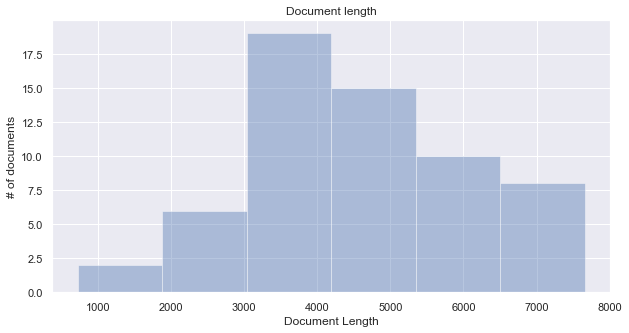

In [64]:
import seaborn as sns

sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (10,5)

lengths = [min(l, 512) for l in length]
sns.distplot(length, kde = False, rug = False)
plt.title('Document length')
plt.xlabel('Document Length')
plt.ylabel('# of documents')

In [65]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 512
print('Padding token: {:}, ID : {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype = 'long', value = 0, truncating = 'post', padding = 'post')

Padding token: [PAD], ID : 0


In [66]:
attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id>0) for token_id in sent]
    attention_masks.append(att_mask)

In [68]:
label = train[1].tolist()
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, label, random_state = 0, test_size = 0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, label, random_state = 0, test_size = 0.1)

In [70]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

C:\Users\user\AppData\Local\Temp/ipykernel_2448/1696369575.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
C:\Users\user\AppData\Local\Temp/ipykernel_2448/1696369575.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_inputs)
C:\Users\user\AppData\Local\Temp/ipykernel_2448/1696369575.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
C:\Users\user\AppData\Local\Temp/ipykernel_2448/1696369575.py:5: UserWarnin

In [86]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

batch_size = 1
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size = batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(validation_data, batch_size = batch_size)

In [73]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels = 4, output_attentions = False, output_hidden_states = False)
device = torch.device('cuda')
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [83]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

In [87]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

total_steps = len(train_dataloader)*epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [88]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(prds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [89]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    
    return str(datetime.timedelta(seconds=elapsed_round))

In [90]:
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):
    print("")
    print("=================Epoch {:}/{:}====================".format(epoch_i+1, epochs))
    print("Training")
    
    t0 = time.time()
    
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 100==0 and not step ==0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,} of {:>5,}. Elapsed: {:}'.format(step, len(train_dataloader), elapsed))
            
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad()
        output = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask, labels = b_labels)
        loss = outputs[0]
        total_loss+=loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss/len(train_dataloader)
    loss_values.append(avg_train_loss)
    
    print("")
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(format_time(time.time() - t0)))
    
    # validation
    print("")
    print("Running Validation")
    t0 = time.time()
    
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            ouputs = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        labels_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps +=1
        
    print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("Validation took: {:}".format(format_time(time.time() - t0)))
    
print("")
print("Training Complete!")       
        
    


=================Epoch 1/5====================
Training


RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 11.00 GiB total capacity; 9.73 GiB already allocated; 0 bytes free; 9.76 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF